# Compare impact of risk aversion on a value diagram

In [1]:
# Copyright 2024 RUVPY Developers

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

from ruvpy.relative_utility_value import relative_utility_value
from ruvpy.damage_functions import logistic_zero
from ruvpy.economic_models import cost_loss, cost_loss_analytical_spend
from ruvpy.utility_functions import cara
from ruvpy.decision_rules import optimise_over_forecast_distribution

# Load example forecast dataset

In [3]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE and event frequency for reference

# load and convert runoff to cumecs
data = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
data *= 1165 / 86.4

# filter to the first week of each month
data = data[(data.index.day >= 1) & (data.index.day <= 7)]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values

print(obs.shape, fcst.shape)

(1932,) (1932, 100)


# Define decision context

In [4]:
parallel_nodes = 2

alpha_step = 0.05
alphas = np.arange(alpha_step, 1, alpha_step)
risk_aversion_coefficients = [0, 0.3, 1, 5]

binary_decision_threshold = np.nanquantile(obs, 0.9)
multicat_decision_thresholds = np.nanquantile(obs, [0.85, 0.90, 0.95, 0.99])

# note there is no utility function or decision thresholds defined, we will add these before calling relative_utility_value
decision_context = {
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.07, 'threshold': np.nanquantile(obs, 0.99)}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_rule': [optimise_over_forecast_distribution, None],
}

ref = None  # tell RUV library to use obs to replicate event frequency reference as in REV

# Calculate RUV using different decision rules

In [5]:
results = xr.DataArray(np.nan, dims=('alpha', 'decision_type', 'risk_aversion'), coords={'alpha': alphas, 'decision_type': ['binary', 'multi_categorical', 'continuous'], 'risk_aversion': risk_aversion_coefficients})

In [6]:
for risk_aversion in risk_aversion_coefficients:
    print('Calculating RUV for risk_aversion_coefficient %.1f' % risk_aversion)

    # add utility function to decision context to set risk aversion
    decision_context['utility_function'] = [cara, {'A': risk_aversion}]
    
    print('Binary')
    decision_context['decision_thresholds'] = np.array([0, binary_decision_threshold])
    results.loc[{'risk_aversion': risk_aversion, 'decision_type': 'binary'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

    print('Multi-categorical')
    decision_context['decision_thresholds'] = np.insert(multicat_decision_thresholds, 0, 0)
    results.loc[{'risk_aversion': risk_aversion, 'decision_type': 'multi_categorical'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

    print('Continuous')
    decision_context['decision_thresholds'] = None
    results.loc[{'risk_aversion': risk_aversion, 'decision_type': 'continuous'}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']


Calculating RUV for risk_aversion_coefficients 0.0
Binary
Multi-categorical
Continuous
Calculating RUV for risk_aversion_coefficients 0.3
Binary
Multi-categorical
Continuous
Calculating RUV for risk_aversion_coefficients 1.0
Binary
Multi-categorical
Continuous
Calculating RUV for risk_aversion_coefficients 5.0
Binary
Multi-categorical
Continuous


# Plot results on a value diagram

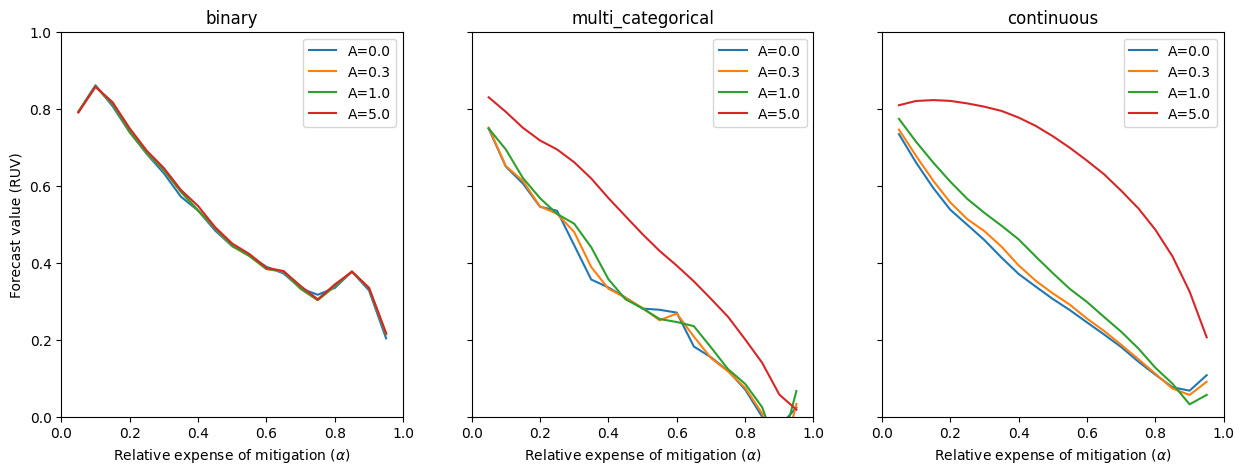

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

risk_aversion_coefficients = results.coords['risk_aversion'].values
decision_types = results.coords['decision_type'].values
alphas = results.coords['alpha'].values

for i, decision_type in enumerate(decision_types):
    ax = axs[i]
    for risk_aversion in risk_aversion_coefficients:
        data = results.sel(risk_aversion=risk_aversion, decision_type=decision_type)
        ax.plot(alphas, data.values, label='A=%.1f' % risk_aversion)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_title(decision_type)
    ax.set_xlabel(r'Relative expense of mitigation ($\alpha$)')
    if i == 0:
        ax.set_ylabel('Forecast value (RUV)')

    ax.legend()

plt.show()